In [1]:
import os, glob, re, numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras import layers, Model, Input
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

FEATURE_DIR = "NSR_SCD_Features_CSV_1h_10min_segments"

In [2]:
def parse_filename(path):
    name = os.path.basename(path)
    is_scd = name.startswith("SCD")
    parts  = name.split('_')
    subj   = parts[1]
    ordinal = parts[2]                # First…Sixth
    order = ["First","Second","Third","Fourth","Fifth","Sixth"]
    idx = order.index(ordinal)
    # SCD order reversed: Sixth→0 … First→5
    idx = 5 - idx if is_scd else idx
    return int(is_scd), subj, idx

In [3]:
def load_subject_dict(feature_dir):
    subj_map = {}
    for path in glob.glob(os.path.join(feature_dir, "*.csv")):
        label, subj, seg_idx = parse_filename(path)
        features = pd.read_csv(path).values.squeeze()   # 12‑element row

        print(label, features)
        if subj not in subj_map:
            subj_map[subj] = {"label": label, "segments": [None]*6}
        subj_map[subj]["segments"][seg_idx] = features
    # check completeness
    # for s, info in subj_map.items():
    #     if None in info["segments"]:
    #         raise ValueError(f"Subject {s} missing segment(s)")
    return subj_map

subject_dict = load_subject_dict(FEATURE_DIR)
print("Loaded", len(subject_dict), "subjects")

0 [0.77871704 0.32125417 0.0390625  0.09967578 0.06323338 0.04719687
 0.24683483 0.03169763 0.485      0.362      0.5625     3.        ]
0 [0.66473883 0.35151649 0.0546875  0.08508657 0.059      0.05011111
 0.26427112 0.03975563 0.531      0.451      0.3671875  2.5       ]
0 [0.78732525 0.3883831  0.015625   0.10077763 0.05770751 0.04769433
 0.26941392 0.03421889 0.438      0.362      0.5546875  3.6796875 ]
0 [0.77215395 0.33053766 0.0546875  0.09883571 0.06036269 0.04650259
 0.23815599 0.03084307 0.466      0.359      0.5        2.7578125 ]
0 [0.79592835 0.3286479  0.0625     0.10187883 0.062      0.04506667
 0.24651377 0.03097186 0.465      0.338      0.5078125  2.9296875 ]
0 [0.77286216 0.34044703 0.03125    0.09892636 0.05692109 0.04333765
 0.24220083 0.03133817 0.44       0.335      0.5859375  2.3671875 ]
0 [0.6974796  0.53079977 0.2578125  0.08927739 0.0966161  0.0957993
 0.35869838 0.0514278  0.828      0.821      0.140625   3.25      ]
0 [0.66210721 0.48248174 0.2265625  0.0847

In [4]:
subject_dict

{'16265': {'label': 0,
  'segments': [array([0.66473883, 0.35151649, 0.0546875 , 0.08508657, 0.059     ,
          0.05011111, 0.26427112, 0.03975563, 0.531     , 0.451     ,
          0.3671875 , 2.5       ]),
   array([0.77215395, 0.33053766, 0.0546875 , 0.09883571, 0.06036269,
          0.04650259, 0.23815599, 0.03084307, 0.466     , 0.359     ,
          0.5       , 2.7578125 ]),
   array([0.77286216, 0.34044703, 0.03125   , 0.09892636, 0.05692109,
          0.04333765, 0.24220083, 0.03133817, 0.44      , 0.335     ,
          0.5859375 , 2.3671875 ]),
   array([0.78732525, 0.3883831 , 0.015625  , 0.10077763, 0.05770751,
          0.04769433, 0.26941392, 0.03421889, 0.438     , 0.362     ,
          0.5546875 , 3.6796875 ]),
   array([0.77871704, 0.32125417, 0.0390625 , 0.09967578, 0.06323338,
          0.04719687, 0.24683483, 0.03169763, 0.485     , 0.362     ,
          0.5625    , 3.        ]),
   array([0.79592835, 0.3286479 , 0.0625    , 0.10187883, 0.062     ,
          0.045

In [5]:
for key in subject_dict.keys():
    subject_dict[key]["segments"] = [np.delete(segment, [2, 3, 4, 8]) for segment in subject_dict[key]["segments"]]

In [6]:
subject_dict

{'16265': {'label': 0,
  'segments': [array([0.66473883, 0.35151649, 0.05011111, 0.26427112, 0.03975563,
          0.451     , 0.3671875 , 2.5       ]),
   array([0.77215395, 0.33053766, 0.04650259, 0.23815599, 0.03084307,
          0.359     , 0.5       , 2.7578125 ]),
   array([0.77286216, 0.34044703, 0.04333765, 0.24220083, 0.03133817,
          0.335     , 0.5859375 , 2.3671875 ]),
   array([0.78732525, 0.3883831 , 0.04769433, 0.26941392, 0.03421889,
          0.362     , 0.5546875 , 3.6796875 ]),
   array([0.77871704, 0.32125417, 0.04719687, 0.24683483, 0.03169763,
          0.362     , 0.5625    , 3.        ]),
   array([0.79592835, 0.3286479 , 0.04506667, 0.24651377, 0.03097186,
          0.338     , 0.5078125 , 2.9296875 ])]},
 '16272': {'label': 0,
  'segments': [array([0.66210721, 0.48248174, 0.09268293, 0.34078106, 0.05146917,
          0.836     , 0.125     , 2.0390625 ]),
   array([0.69573086, 0.53191763, 0.08694639, 0.40399782, 0.05806812,
          0.746     , 0.1171875 

In [7]:
X_tr, y_tr, X_te, y_te = [], [], [], []

for subj, info in subject_dict.items():
    lbl  = info["label"]
    segs = info["segments"]
    X_tr.append(segs[0])              # first 10‑min
    y_tr.append(lbl)
    X_te.extend(segs[1:])             # remaining 5
    y_te.extend([lbl]*5)

In [8]:
X_tr = np.vstack(X_tr)
#X_te = np.vstack(X_te)
y_tr = np.array(y_tr)
#y_te = np.array(y_te)

In [9]:
scaler = StandardScaler().fit(X_tr)

In [10]:
X_tr = scaler.transform(X_tr)
#X_te = scaler.transform(X_te)

In [11]:
X_tr

array([[-1.95264711e-01, -3.20301007e-01, -2.65063357e+00,
        -2.98163333e-01, -6.13341266e-01, -1.03157900e+00,
         1.72473028e+00, -3.27084948e-01],
       [-1.99644040e-01, -2.67729024e-01,  5.76020393e-01,
        -2.57032502e-01, -3.85100234e-01,  1.04149408e-01,
        -1.20494855e+00, -3.50534114e-01],
       [-4.95860113e-02, -3.07524080e-01, -2.42995721e+00,
        -2.90265642e-01, -6.65433290e-01, -1.12007731e+00,
         4.01649517e-01, -2.82173834e-01],
       [-1.59159599e-01, -3.24472523e-01, -1.10320847e+00,
        -2.98377897e-01, -6.38958613e-01, -5.47788195e-01,
        -1.01593701e+00, -3.18341191e-01],
       [-6.95025217e-01, -3.51393649e-01,  7.11068207e-01,
        -3.48629050e-01, -4.76900160e-01,  2.21925919e+00,
        -6.37913939e-01, -3.83521923e-01],
       [-6.23538326e-01, -3.65420679e-01,  9.42488109e-02,
        -3.30994315e-01, -4.16072879e-01,  1.38147512e+00,
        -1.20494855e+00, -3.39405696e-01],
       [-6.15077375e-01, -3.222305

In [12]:
N_FILT, K, DIL_BASE, DROP, DENSE = 64, 2, [1,2,4,8,16,32,64], 0.5, 512

# def build_wavenet(depth, lr):
#     dil = DIL_BASE[:depth]
#     inp = Input(shape=(9,))
#     x   = layers.Reshape((9,1))(inp); skips=[]
#     for d in dil:
#         t=layers.Conv1D(N_FILT,K,padding='causal',dilation_rate=d,activation='tanh')(x)
#         s=layers.Conv1D(N_FILT,K,padding='causal',dilation_rate=d,activation='sigmoid')(x)
#         g=layers.Multiply()([t,s])
#         skips.append(layers.TimeDistributed(layers.Dense(N_FILT,activation='relu'))(g))
#         x=layers.Add()([x,g])
#     x=layers.Add()(skips); x=layers.Activation('relu')(x); x=layers.Flatten()(x)
#     x=layers.Dropout(DROP)(x); x=layers.Dense(DENSE,activation='relu')(x); x=layers.Dropout(DROP)(x)
#     out=layers.Dense(1,activation='sigmoid')(x)
#     m=Model(inp,out); m.compile(tf.keras.optimizers.Adam(lr),'binary_crossentropy',['accuracy'])
#     return m

def build_wavenet(depth, lr):
    dilations = DIL_BASE[:depth]
    inp = Input(shape=(8,))
    x   = layers.Reshape((8,1))(inp)
    skips = []
    for d in dilations:
        t = layers.Conv1D(N_FILT, K, padding="causal",
                          dilation_rate=d, activation="tanh")(x)
        s = layers.Conv1D(N_FILT, K, padding="causal",
                          dilation_rate=d, activation="sigmoid")(x)
        g = layers.Multiply()([t, s])
        skips.append(layers.TimeDistributed(layers.Dense(N_FILT,
                               activation="relu"))(g))
        x = layers.Add()([x, g])          # residual
    x = layers.Add()(skips)
    x = layers.Activation("relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dropout(DROP)(x)
    x = layers.Dense(DENSE, activation="relu")(x)
    x = layers.Dropout(DROP)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                  loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [13]:
configs = [(3,0.1,32),(5,0.01,64),(7,0.001,128),(9,0.0001,256)]
histories, models = {}, {}
for d,lr,bs in configs:
    key=f"d{d}_lr{lr}_bs{bs}"
    print("Training",key)
    m=build_wavenet(d,lr)
    h=m.fit(X_tr,y_tr,epochs=50,batch_size=bs,verbose=0)   # no validation
    histories[key]=h
    models[key]=m
    print("  final loss=",h.history['loss'][-1]," acc=",h.history['accuracy'][-1])

Training d3_lr0.1_bs32
  final loss= 27.974254608154297  acc= 0.9722222089767456
Training d5_lr0.01_bs64
  final loss= 1.4343338079925161e-05  acc= 1.0
Training d7_lr0.001_bs128
  final loss= 0.0025746228639036417  acc= 1.0
Training d9_lr0.0001_bs256
  final loss= 0.3205481171607971  acc= 0.9166666865348816


In [14]:
best_key = min(histories,
               key=lambda k:(histories[k].history['loss'][-1],
                             -histories[k].history['accuracy'][-1]))
best_model = models[best_key]
print("BEST model →", best_key)

BEST model → d5_lr0.01_bs64


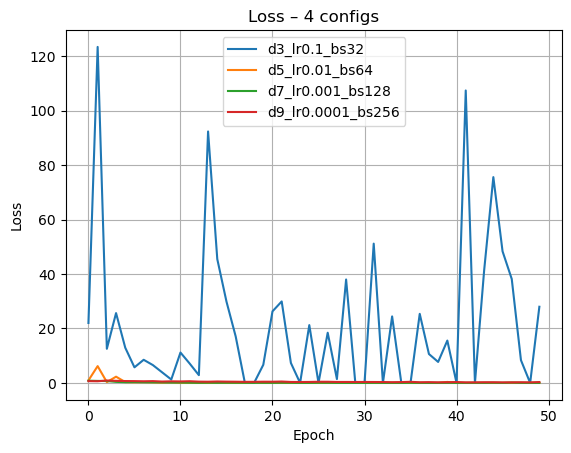

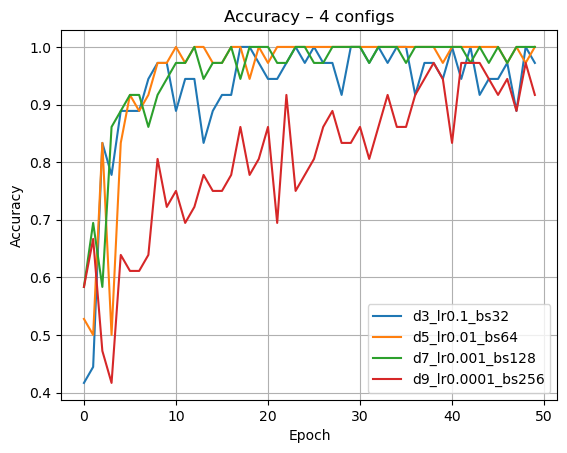

In [15]:
import matplotlib.pyplot as plt
# 1+2 plots
plt.figure(); 
plt.title("Loss – 4 configs")
for k in histories: 
    plt.plot(histories[k].history['loss'], label=k)
plt.legend(); 
plt.xlabel("Epoch"); 
plt.ylabel("Loss"); 
plt.grid(); 
plt.show()

plt.figure(); 
plt.title("Accuracy – 4 configs")
for k in histories: 
    plt.plot(histories[k].history['accuracy'], label=k)
plt.legend(); 
plt.xlabel("Epoch"); 
plt.ylabel("Accuracy"); 
plt.grid(); 
plt.show()

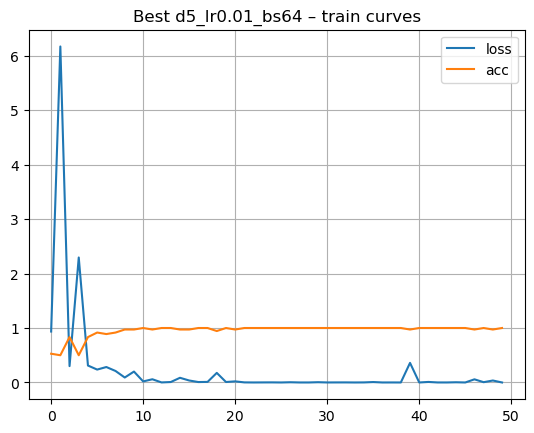

In [16]:
# 3 detailed curve for best
h=histories[best_key]
plt.figure(); 
plt.plot(h.history['loss'],label='loss'); 
plt.plot(h.history['accuracy'],label='acc')
plt.title(f"Best {best_key} – train curves"); 
plt.legend(); 
plt.grid(); 
plt.show()

In [17]:
slice_X, slice_y = [[] for _ in range(5)], [[] for _ in range(5)]

for subj, info in subject_dict.items():
    lbl  = info["label"]
    for i in range(5):
        slice_X[i].append(info["segments"][i+1])
        slice_y[i].append(lbl)

In [18]:
slice_X = [np.vstack(s) for s in slice_X]
slice_y = [np.array(s)   for s in slice_y]

In [22]:
# 4 confusion per slice
global_cm=np.zeros((2,2),int)
for i,(X_s,y_s) in enumerate(zip(slice_X,slice_y),start=2):
    y_pr=(models['d9_lr0.0001_bs256'].predict(X_s).ravel()>=0.5).astype(int)
    cm=confusion_matrix(y_s,y_pr); global_cm+=cm
    tn,fp,fn,tp=cm.ravel()
    acc=(tp+tn)/cm.sum(); sens=tp/(tp+fn); spec=tn/(tn+fp); prec=tp/(tp+fp)
    print(f"Slice {i}‑th 5‑min  CM={cm.tolist()}  Acc={acc:.3f}  Sens={sens:.3f}  Spec={spec:.3f}  Prec={prec:.3f}")
    print(f"\\nGLOBAL CM =\\n", global_cm)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
Slice 2‑th 5‑min  CM=[[0, 18], [0, 18]]  Acc=0.500  Sens=1.000  Spec=0.000  Prec=0.500
\nGLOBAL CM =\n [[ 0 18]
 [ 0 18]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Slice 3‑th 5‑min  CM=[[0, 18], [0, 18]]  Acc=0.500  Sens=1.000  Spec=0.000  Prec=0.500
\nGLOBAL CM =\n [[ 0 36]
 [ 0 36]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Slice 4‑th 5‑min  CM=[[0, 18], [0, 18]]  Acc=0.500  Sens=1.000  Spec=0.000  Prec=0.500
\nGLOBAL CM =\n [[ 0 54]
 [ 0 54]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Slice 5‑th 5‑min  CM=[[0, 18], [0, 18]]  Acc=0.500  Sens=1.000  Spec=0.000  Prec=0.500
\nGLOBAL CM =\n [[ 0 72]
 [ 0 72]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Slice 6‑th 5‑min  CM=[[0, 18], [0, 18]]  Acc=0.500  Sens=1.000  Spec=0.000  Prec=0.500
\nGLOBAL CM =\n [[ 0 90]
 [ 0 90]]


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2, rc={"figure.dpi":120})

# ──────────────────────────────────────────
# ① Loss curves of the four configs
plt.figure()
for k,h in histories.items():
    plt.plot(h.history['loss'], label=k)
plt.title("Training loss – 4 WaveNet configs")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.legend()
plt.show()

# ② Accuracy curves of the four configs
plt.figure()
for k,h in histories.items():
    plt.plot(h.history['accuracy'], label=k)
plt.title("Training accuracy – 4 WaveNet configs")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.grid(True); plt.legend()
plt.show()

In [ ]:
# ③ Detailed loss + acc for the best model
best_hist = histories[best_key]
fig, ax1 = plt.subplots()
ax1.plot(best_hist.history['loss'], label="loss", color="tab:red")
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss", color="tab:red")
ax2 = ax1.twinx()
ax2.plot(best_hist.history['accuracy'], label="acc", color="tab:blue")
ax2.set_ylabel("Accuracy", color="tab:blue")
plt.title(f"Best model ({best_key}) – training curves")
fig.tight_layout(); plt.grid(True); plt.show()

In [ ]:
# ──────────────────────────────────────────
# ④ Slice‑wise confusion matrices (heat‑maps)
labels = ["NSR", "SCD"]
global_cm = np.zeros((2,2), int)

for idx, (X_s, y_s) in enumerate(zip(slice_X, slice_y), start=2):
    y_pred = (best_model.predict(X_s).ravel() >= 0.5).astype(int)
    cm = confusion_matrix(y_s, y_pred)
    global_cm += cm

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title(f"{idx}ᵗʰ 5‑minute slice – Confusion Matrix")
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    acc  = (tp + tn) / cm.sum()
    sens = tp / (tp + fn) if (tp+fn) else 0
    spec = tn / (tn + fp) if (tn+fp) else 0
    prec = tp / (tp + fp) if (tp+fp) else 0
    print(f"Slice {idx}:  Acc={acc:.3f}  Sens={sens:.3f}  "
          f"Spec={spec:.3f}  Prec={prec:.3f}")